In [ ]:
!pip install transformers torchaudio

## 마운트

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

%cd /content/drive/MyDrive/Projects/LikeLion

Mounted at /content/drive
/content/drive/MyDrive/Projects/LikeLion


In [ ]:
# TRAIN_CSV_PATH = "./train/train.csv"
# TRAIN_AUDIO_TAR = "./train/train_audio.tar"
# VALID_CSV_PATH = "./validation/validation.csv"
# VALID_AUDIO_TAR = "./validation/valid_audio.tar"

## 코드

In [ ]:
import os
import random
import ast
from typing import List, Dict
import io
import tarfile

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, DataLoader
from transformers import AutoFeatureExtractor, Wav2Vec2Model, AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# =========================================
# 1. 환경 설정 및 랜덤 시드 고정
# =========================================
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
SEED = 42
BATCH_SIZE = 16
NUM_EPOCHS = 1
TEXT_MODEL_NAME = "beomi/KcELECTRA-base"
TRAIN_CSV_PATH = "./train/train.csv"
TRAIN_AUDIO_TAR = "./train/train_audio.tar"
VALID_CSV_PATH = "./validation/validation.csv"
VALID_AUDIO_TAR = "./validation/valid_audio.tar"
MAX_TEXT_LEN = 128
SAMPLE_RATE = 16000
MAX_AUDIO_FRAMES = 400
MIN_AUDIO_FRAMES = 8

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

# =========================================
# 2. 텍스트 전처리 함수
# =========================================
tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL_NAME)

def preprocess_text(text: str, tokenizer, max_length: int = MAX_TEXT_LEN) -> Dict[str, torch.Tensor]:
    if isinstance(text, str) and len(text.strip()) > 0:
        sentences = [s.strip().strip('"') for s in text.split(',') if s.strip()]
    else:
        sentences = []
    joined_text = ' [SEP] '.join(sentences) if sentences else ''
    enc = tokenizer(
        joined_text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    return {k: v.squeeze(0) for k, v in enc.items()}

# =========================================
# 3. wav2vec2-XLSR 모델 초기화
# =========================================
# wav2vec2-XLSR 모델 초기화
W2V_MODEL_NAME = "facebook/wav2vec2-xls-r-300m"  # 멀티링구얼 모델 (한국어 포함)
w2v_fe = AutoFeatureExtractor.from_pretrained(W2V_MODEL_NAME)
w2v_model = Wav2Vec2Model.from_pretrained(W2V_MODEL_NAME).to(device)
# w2v_model = Wav2Vec2Model.from_pretrained(
#     W2V_MODEL_NAME,
#     use_safetensors=True,   # safetensors 우선
#     cache_dir="./hf_cache"  # (선택) 캐시 위치 고정
# ).to(device)
w2v_model.eval()

# 여기!
for p in w2v_model.parameters():
    p.requires_grad = False

# 샘플링 레이트
SAMPLE_RATE = 16000
MIN_AUDIO_FRAMES = 8
MAX_AUDIO_FRAMES = 400

# =========================================
# 4. Dataset 정의
# =========================================
class TextAudioDataset(Dataset):
    def __init__(self, df: pd.DataFrame, meta_cols: List[str], audio_tar_path: str,
                 urgency_map: Dict[str, float], sentiment_map: Dict[str, int]):
        self.df = df.reset_index(drop=True)
        self.meta_cols = meta_cols
        self.audio_tar_path = audio_tar_path
        self.urgency_map = urgency_map
        self.sentiment_map = sentiment_map

        # 메타데이터 인덱스 매핑
        self.meta_maps = {}
        self.meta_vocab_sizes = {}
        for col in meta_cols:
            uniques = list(df[col].dropna().unique())
            self.meta_maps[col] = {v: (i + 1) for i, v in enumerate(uniques)}
            self.meta_vocab_sizes[col] = len(uniques) + 1

        # 오디오 로딩 (tar 내부)
        self.audio_data = {}
        if audio_tar_path and os.path.exists(audio_tar_path):
            mode = 'r:gz' if audio_tar_path.endswith(('.tar.gz', '.tgz')) else 'r'
            with tarfile.open(audio_tar_path, mode) as tar:
                for member in tar.getmembers():
                    if member.isfile():
                        f = tar.extractfile(member)
                        if f:
                            self.audio_data[os.path.basename(member.name)] = f.read()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # -----------------------------
        # 1) 텍스트 처리
        # -----------------------------
        text_enc = preprocess_text(row.get('text', ''), tokenizer, MAX_TEXT_LEN)

        # -----------------------------
        # 2) wav2vec2-XLSR 오디오 처리
        # -----------------------------
        audio_paths = []
        if 'audio_split_list' in row and pd.notna(row['audio_split_list']):
            try:
                audio_paths = ast.literal_eval(row['audio_split_list'])
                if not isinstance(audio_paths, (list, tuple)):
                    audio_paths = []
            except Exception:
                audio_paths = []

        features = []
        for audio_file in audio_paths:
            audio_bytes = self.audio_data.get(audio_file)
            if audio_bytes is None:
                features.append(None)
                continue
            try:
                waveform, sr = torchaudio.load(io.BytesIO(audio_bytes))  # (ch, T)
            except Exception:
                features.append(None)
                continue

            # mono + 16k
            if waveform.dim() == 2 and waveform.size(0) > 1:
                waveform = waveform.mean(dim=0, keepdim=True)
            if sr != SAMPLE_RATE:
                waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)

            with torch.no_grad():
                fe_out = w2v_fe(
                    waveform.squeeze(0).numpy(), sampling_rate=SAMPLE_RATE, return_tensors="pt"
                )
                input_values = fe_out.input_values.to(device)  # (1, T')
                out = w2v_model(input_values)                  # (1, t, d)
                hs = out.last_hidden_state.squeeze(0)          # (t, d)
                hs = hs.transpose(0, 1).contiguous()           # (d, t)

                # 프레임 패딩/자르기 (기존 하이퍼 재사용)
                frames = hs.size(1)
                if frames < MAX_AUDIO_FRAMES:
                    hs = torch.nn.functional.pad(hs, (0, MAX_AUDIO_FRAMES - frames))  # ← 무조건 MAX에 맞추기
                else:
                    hs = hs[:, :MAX_AUDIO_FRAMES]
                features.append(hs)

        # 여러 조각 평균, 없으면 0-텐서
        D = w2v_model.config.hidden_size  # 예: 1024(300m)
        if len(features) == 0:
            audio_feat = torch.zeros(D, MAX_AUDIO_FRAMES, device=device)
        else:
            # 조각들 길이 확인
            lengths = [f.size(1) for f in features if f is not None]
            target_T = MIN_AUDIO_FRAMES if len(lengths) == 0 else min(MAX_AUDIO_FRAMES, max(lengths))

            fixed = []
            for f in features:
                if f is None:
                    fixed.append(torch.zeros(D, target_T, device=device))
                    continue
                t = f.size(1)
                if t < target_T:
                    f = torch.nn.functional.pad(f, (0, target_T - t))
                elif t > target_T:
                    f = f[:, :target_T]
                fixed.append(f)

            audio_feat = torch.stack(fixed, dim=0).mean(dim=0)  # (D, target_T)

        # -----------------------------
        # 3) 메타데이터 처리
        # -----------------------------
        meta_idx = []
        for col in self.meta_cols:
            val = row.get(col, None)
            idx_val = 0 if pd.isna(val) or val is None else self.meta_maps.get(col, {}).get(val, 0)
            vocab_size = self.meta_vocab_sizes.get(col, 1)
            idx_val = max(0, min(idx_val, vocab_size-1))
            meta_idx.append(idx_val)
        meta_idx = torch.tensor(meta_idx, dtype=torch.long) if meta_idx else torch.tensor([0], dtype=torch.long)

        # -----------------------------
        # 4) Labels 처리
        # -----------------------------
        urg_val = row.get('urgencyLevel', None)
        urgency = self.urgency_map.get(urg_val, self.urgency_map.get(str(urg_val), 0.0))
        try:
            urgency = float(urgency)
        except Exception:
            urgency = 0.0
        urgency = torch.tensor(urgency, dtype=torch.float)

        sent_val = row.get('sentiment', None)
        sentiment_idx = self.sentiment_map.get(sent_val, self.sentiment_map.get(str(sent_val), 0))
        num_classes = max(1, len(self.sentiment_map))
        sentiment_idx = max(0, min(sentiment_idx, num_classes-1))
        sentiment = torch.tensor(sentiment_idx, dtype=torch.long)

        return {
            'input_ids': text_enc['input_ids'].to(device),
            'attention_mask': text_enc['attention_mask'].to(device),
            'audio_feat': audio_feat.to(device),
            'meta_idx': meta_idx.to(device),
            'urgency': urgency.to(device),
            'sentiment': sentiment.to(device)
        }

# =========================================
# 3-1. collate_fn: dynamic padding
# =========================================
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    meta_idx = torch.stack([item['meta_idx'] for item in batch])
    urgency = torch.stack([item['urgency'] for item in batch])
    sentiment = torch.stack([item['sentiment'] for item in batch])

    audio_feats = [item['audio_feat'] for item in batch]
    max_frames = max([feat.size(1) for feat in audio_feats])
    padded_audio = [torch.nn.functional.pad(feat, (0, max_frames - feat.size(1))) for feat in audio_feats]
    audio_feat = torch.stack(padded_audio)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'audio_feat': audio_feat,
        'meta_idx': meta_idx,
        'urgency': urgency,
        'sentiment': sentiment
    }

# =========================================
# 4. 모델 정의 (wav2vec2-XLSR용)
# =========================================
class MultimodalClassifier(nn.Module):
    def __init__(self, text_model_name, meta_maps: Dict[str, Dict],
                 audio_emb_dim=256, joint_dim=256, num_classes_sentiment=4,
                 audio_input_dim=None):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        self.text_proj = nn.Linear(self.text_encoder.config.hidden_size, joint_dim)

        if audio_input_dim is None:
            audio_input_dim = w2v_model.config.hidden_size  # wav2vec2-XLSR의 hidden dim

        self.audio_proj_shared   = nn.Linear(audio_input_dim, audio_emb_dim)
        self.audio_proj_urgency  = nn.Linear(audio_emb_dim, joint_dim)
        self.audio_proj_sentiment= nn.Linear(audio_emb_dim, joint_dim)

        self.meta_embs = nn.ModuleDict()
        for k, mapping in meta_maps.items():
            num_embeddings = len(mapping) + 1
            emb_dim = min(8, num_embeddings)
            self.meta_embs[k] = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=emb_dim, padding_idx=0)
        self.meta_out_dim = sum([emb.embedding_dim for emb in self.meta_embs.values()]) if self.meta_embs else 0

        self.urgency_head = nn.Linear(joint_dim + self.meta_out_dim, 1)
        self.sentiment_head = nn.Sequential(
            nn.Linear(joint_dim + self.meta_out_dim, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, num_classes_sentiment)
        )

    def forward(self, input_ids, attention_mask, audio_feat, meta_idx):
        B = input_ids.size(0)
        txt_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        txt_emb = self.text_proj(txt_out.last_hidden_state[:, 0, :])

        # audio_feat: (B, D, T)
        audio_mean = audio_feat.mean(dim=2)  # (B, D)
        audio_emb = self.audio_proj_shared(audio_mean)
        audio_emb_urgency  = self.audio_proj_urgency(audio_emb)
        audio_emb_sentiment= self.audio_proj_sentiment(audio_emb)

        if not self.meta_embs:
            meta_emb = torch.zeros(B, 0, device=input_ids.device)
        else:
            if meta_idx.dim() == 1:
                meta_idx = meta_idx.unsqueeze(0).expand(B, -1)
            meta_embeddings = [self.meta_embs[k](meta_idx[:, i].clamp(0, self.meta_embs[k].num_embeddings-1))
                               for i, k in enumerate(self.meta_embs.keys())]
            meta_emb = torch.cat(meta_embeddings, dim=1)

        joint_urgency   = txt_emb + audio_emb_urgency
        joint_sentiment = txt_emb + audio_emb_sentiment

        urg_out  = self.urgency_head(torch.cat([joint_urgency, meta_emb], dim=1)).squeeze(1)
        sent_out = self.sentiment_head(torch.cat([joint_sentiment, meta_emb], dim=1))
        return urg_out, sent_out

# =========================================
# 5. 학습 함수
# =========================================
def train_model(df_train, df_valid, meta_cols, train_tar, valid_tar,
                urgency_map, sentiment_map,
                num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE):

    meta_maps = {col: {v: (i + 1) for i, v in enumerate(df_train[col].dropna().unique())} for col in meta_cols}
    train_dataset = TextAudioDataset(df_train, meta_cols, train_tar, urgency_map, sentiment_map)
    valid_dataset = TextAudioDataset(df_valid, meta_cols, valid_tar, urgency_map, sentiment_map)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    model = MultimodalClassifier(
        TEXT_MODEL_NAME, meta_maps,
        num_classes_sentiment=len(sentiment_map),
        audio_input_dim=w2v_model.config.hidden_size  # wav2vec2-XLSR의 hidden dim
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    criterion_reg = nn.MSELoss()
    criterion_cls = nn.CrossEntropyLoss()

    train_losses, train_reg_losses, train_cls_losses = [], [], []
    valid_losses, valid_reg_losses, valid_cls_losses = [], [], []
    mse_list, mae_list, acc_list, f1_list = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss, total_train_reg, total_train_cls = 0, 0, 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            optimizer.zero_grad()
            pred_urg, pred_sent = model(batch['input_ids'], batch['attention_mask'],
                                        batch['audio_feat'], batch['meta_idx'])
            reg_loss = criterion_reg(pred_urg, batch['urgency'])
            cls_loss = criterion_cls(pred_sent, batch['sentiment'])
            loss = reg_loss + cls_loss
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_reg += reg_loss.item()
            total_train_cls += cls_loss.item()

        train_losses.append(total_train_loss / len(train_loader))
        train_reg_losses.append(total_train_reg / len(train_loader))
        train_cls_losses.append(total_train_cls / len(train_loader))

        model.eval()
        total_valid_loss, total_valid_reg, total_valid_cls = 0, 0, 0
        all_urg_pred, all_urg_true = [], []
        all_sent_pred, all_sent_true = [], []

        with torch.no_grad():
            for batch in tqdm(valid_loader, desc=f"Epoch {epoch+1} [Valid]"):
                pred_urg, pred_sent = model(batch['input_ids'], batch['attention_mask'],
                                            batch['audio_feat'], batch['meta_idx'])
                reg_loss = criterion_reg(pred_urg, batch['urgency'])
                cls_loss = criterion_cls(pred_sent, batch['sentiment'])
                loss = reg_loss + cls_loss

                total_valid_loss += loss.item()
                total_valid_reg += reg_loss.item()
                total_valid_cls += cls_loss.item()

                all_urg_pred.extend(pred_urg.cpu().numpy())
                all_urg_true.extend(batch['urgency'].cpu().numpy())
                all_sent_pred.extend(pred_sent.argmax(dim=1).cpu().numpy())
                all_sent_true.extend(batch['sentiment'].cpu().numpy())

        valid_losses.append(total_valid_loss / len(valid_loader))
        valid_reg_losses.append(total_valid_reg / len(valid_loader))
        valid_cls_losses.append(total_valid_cls / len(valid_loader))

        mse = mean_squared_error(all_urg_true, all_urg_pred)
        mae = mean_absolute_error(all_urg_true, all_urg_pred)
        acc = accuracy_score(all_sent_true, all_sent_pred)
        f1 = f1_score(all_sent_true, all_sent_pred, average='weighted')

        mse_list.append(mse)
        mae_list.append(mae)
        acc_list.append(acc)
        f1_list.append(f1)

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f} | Valid Loss: {valid_losses[-1]:.4f}")
        print(f"Train Reg Loss: {train_reg_losses[-1]:.4f} | Train Cls Loss: {train_cls_losses[-1]:.4f}")
        print(f"Valid Reg Loss: {valid_reg_losses[-1]:.4f} | Valid Cls Loss: {valid_cls_losses[-1]:.4f}")
        print(f"Regression -> MSE: {mse:.4f}, MAE: {mae:.4f}")
        print(f"Classification -> Accuracy: {acc:.4f}, Weighted F1: {f1:.4f}\n")

    scores = {
        'train_loss': train_losses, 'train_reg_loss': train_reg_losses, 'train_cls_loss': train_cls_losses,
        'valid_loss': valid_losses, 'valid_reg_loss': valid_reg_losses, 'valid_cls_loss': valid_cls_losses,
        'mse': mse_list, 'mae': mae_list, 'accuracy': acc_list, 'f1': f1_list
    }
    return model, scores

# =========================================
# 6. 학습 결과 시각화
# =========================================
def plot_scores(scores):
    epochs = range(1, len(scores['train_loss'])+1)
    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    plt.plot(epochs, scores['train_reg_loss'], label='Train Reg Loss')
    plt.plot(epochs, scores['train_cls_loss'], label='Train Cls Loss')
    plt.plot(epochs, scores['valid_reg_loss'], '--', label='Valid Reg Loss')
    plt.plot(epochs, scores['valid_cls_loss'], '--', label='Valid Cls Loss')
    plt.title('Regression & Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, scores['mse'], label='MSE')
    plt.plot(epochs, scores['mae'], label='MAE')
    plt.plot(epochs, scores['accuracy'], label='Accuracy')
    plt.plot(epochs, scores['f1'], label='F1 Score')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    plt.show()

device : cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(500, 15)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch 1 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 1/1
Train Loss: 1.8919 | Valid Loss: 1.6277
Train Reg Loss: 0.6987 | Train Cls Loss: 1.1932
Valid Reg Loss: 0.6571 | Valid Cls Loss: 0.9706
Regression -> MSE: 0.6529, MAE: 0.6665
Classification -> Accuracy: 0.5700, Weighted F1: 0.4139



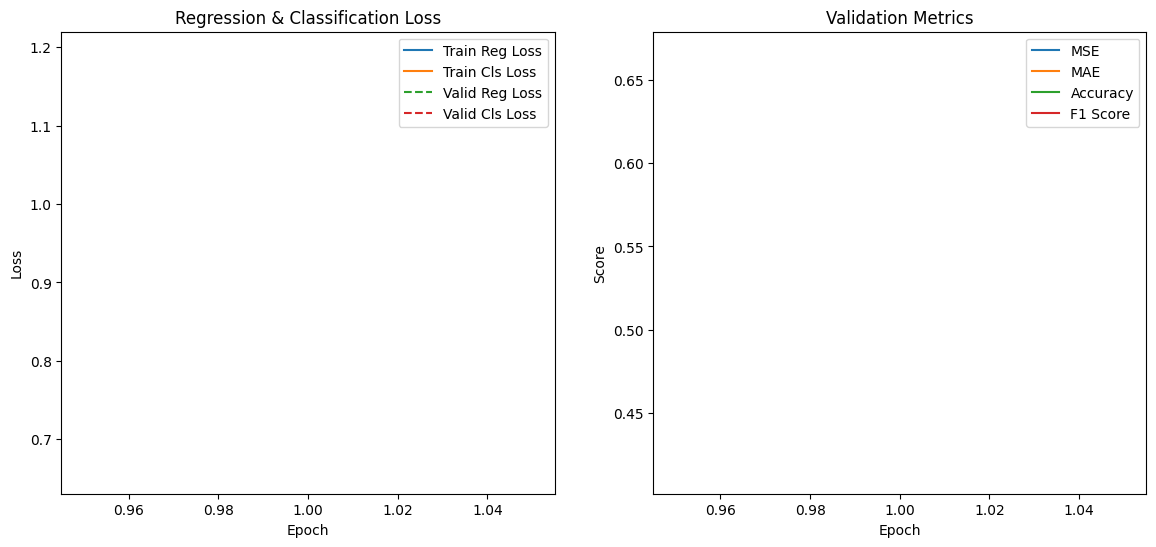

In [ ]:
# =========================================
# 7. 학습 실행
# =========================================
df = pd.read_csv(TRAIN_CSV_PATH)

# [아람EDITED] - disasterLarge 비율 유지하여 약 500개로 다운샘플
LABEL_COL = "disasterLarge"  # 비율 기준 컬럼명
TARGET_N = 500               # 다운샘플 목표 개수
RS = SEED

if LABEL_COL in df.columns and len(df) > TARGET_N:
    # --- Stratified downsample (Largest Remainder Method) ---
    counts = df[LABEL_COL].value_counts(dropna=False)
    probs = counts / counts.sum()
    raw = probs * TARGET_N

    base = np.floor(raw).astype(int)                # 기본 할당
    leftover = int(TARGET_N - base.sum())           # 남은 몫
    # 가장 큰 소수점부터 1개씩 추가
    remainders = (raw - base).sort_values(ascending=False)

    alloc = base.copy()
    for lbl in remainders.index[:leftover]:
        alloc[lbl] += 1

    # 각 그룹에서 할당 수만큼 샘플 (그룹 실제 크기보다 큰 경우 cap)
    parts = []
    for lbl, n_take in alloc.items():
        grp = df[df[LABEL_COL] == lbl]
        n_final = min(len(grp), int(n_take))
        if n_final > 0:
            parts.append(grp.sample(n=n_final, random_state=RS))
    df = pd.concat(parts, axis=0).sample(frac=1.0, random_state=RS).reset_index(drop=True)
print(df.shape)
# [아람EDITED]

meta_cols = [c for c in df.columns if c not in ['text','audio_split_list','urgencyLevel','sentiment']]

urgency_map = {'상': 2.0, '중': 1.0, '하': 0.0}
sentiment_map = {'불안/걱정':0, '당황/난처':1, '중립':2, '기타부정':3}

valid_size = int(len(df) * 0.2)
df_train = df.iloc[:-valid_size].reset_index(drop=True)
df_valid = df.iloc[-valid_size:].reset_index(drop=True)

# 모델 학습 및 평가
model, scores = train_model(df_train, df_valid, meta_cols,
                            TRAIN_AUDIO_TAR, VALID_AUDIO_TAR,
                            urgency_map, sentiment_map)

# 학습 결과 시각화
plot_scores(scores)

In [ ]:
# =========================================
# 10. 테스트 평가
# =========================================
print("========================= 테스트 =========================")
df_test = pd.read_csv(VALID_CSV_PATH)

test_dataset = TextAudioDataset(df_test, meta_cols, VALID_AUDIO_TAR, urgency_map, sentiment_map)

# [수정] num_workers=0 으로 변경, pin_memory=False (기본값)
# Dataset의 __getitem__에서 이미 .to(device)로 GPU에 텐서를 올리고 있으므로,
# 멀티프로세싱(num_workers>0)을 사용하면 CUDA 에러가 발생합니다.
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         collate_fn=collate_fn, # collate_fn 추가
                         num_workers=0,      # 수정
                         pin_memory=False)   # 수정

model.eval()
preds_urgency, preds_sentiment, labels_urgency, labels_sentiment = [], [], [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        audio_feat = batch['audio_feat']
        meta_idx = batch['meta_idx']
        label_urgency = batch['urgency']
        label_sentiment = batch['sentiment']

        pred_urgency, pred_sentiment = model(input_ids, attention_mask, audio_feat, meta_idx)

        preds_urgency.extend(pred_urgency.cpu().tolist())
        preds_sentiment.extend(torch.argmax(pred_sentiment, dim=1).cpu().tolist())
        labels_urgency.extend(label_urgency.cpu().tolist())
        labels_sentiment.extend(label_sentiment.cpu().tolist())

mae = mean_absolute_error(labels_urgency, preds_urgency)
acc = accuracy_score(labels_sentiment, preds_sentiment)
f1 = f1_score(labels_sentiment, preds_sentiment, average='weighted') # F1 스코어 추가

print(f"Test MAE (urgencyLevel): {mae:.4f}")
print(f"Test Accuracy (sentiment): {acc:.4f}")
print(f"Test Weighted F1 (sentiment): {f1:.4f}")

========================= 테스트 =========================


Test:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/i